In [35]:
!pip install librosa onnx onnxruntime tf2onnx tensorflow_io flatbuffers==24.3.25

INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached tf2onnx-1.16.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.0-py3-none-any.whl.metadata (1.2 kB)
INFO: pip is still looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.3/345.3 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: tf2onnx
    Found existing installation: tf2onnx 1.14.0
    Uninstalling tf2onnx-1.14.0:
      Succe

In [40]:
!pip install librosa soundfile scipy


In [42]:
# Install librosa if needed (uncomment if required)
# !pip install librosa tensorflow-io

import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import librosa


# Load audio files (upload your files first in Colab Files panel or use wget to download)
noisy, _ = librosa.load("nsa_st.wav", sr=16000)
clean, _ = librosa.load("nst.wav", sr=16000)

# Configuration
config = {
    "window_size": 512,
    "hop_length": 256,
    "input_shape": [256, 256],
    "dropout_rate": 0.3,
    "batch_size": 1,
    "epochs": 10,
    "sample_rate": 16000,
}

# Convert audio to normalized spectrogram
def audio_to_spectrogram(audio):
    stft = librosa.stft(audio, n_fft=config['window_size'], hop_length=config['hop_length'])
    mag = np.abs(stft)
    spec_db = librosa.amplitude_to_db(mag, ref=np.max)
    spec_db_norm = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
    return tf.convert_to_tensor(spec_db_norm, dtype=tf.float32), spec_db.min(), spec_db.max()

def preprocess_audio(audio):
    spec_db_norm, min_val, max_val = audio_to_spectrogram(audio)
    spec_db_norm = tf.image.resize(spec_db_norm[..., tf.newaxis], config['input_shape'])
    return tf.expand_dims(spec_db_norm, axis=0), min_val, max_val  # Add batch dim

def create_unet_model():
    input_layer = Input(shape=(config['input_shape'][0], config['input_shape'][1], 1))

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(config['dropout_rate'])(conv1)
    pool1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(config['dropout_rate'])(conv2)
    pool2 = MaxPooling2D(2)(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(config['dropout_rate'])(conv3)

    up1 = concatenate([Conv2DTranspose(64, 2, strides=2, padding='same')(conv3), conv2])
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(config['dropout_rate'])(conv4)

    up2 = concatenate([Conv2DTranspose(32, 2, strides=2, padding='same')(conv4), conv1])
    output_layer = Conv2D(1, 1, activation='sigmoid')(up2)

    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['mae'])
    return model




In [44]:

# Prepare data
noisy_input, _, _ = preprocess_audio(noisy)
clean_target, _, _ = preprocess_audio(clean)

print(f"Noisy input shape: {noisy_input.shape}")
print(f"Clean target shape: {clean_target.shape}")

# Build and train model
model = create_unet_model()
model.summary()

history = model.fit(noisy_input, clean_target, epochs=config['epochs'])

# Save the model
model.save('deepspeech_colab.h5')



Noisy input shape: (1, 256, 256, 1)
Clean target shape: (1, 256, 256, 1)


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_63[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 128, 128,  │          0 │ dropout_28[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_65[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ dropout_29[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 64, 64,    │    147,584 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_67[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 128, 128,  │     32,832 │ dropout_30[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 128, 128,  │          0 │ conv2d_transpose

 Total params: 744,449 (2.84 MB)

 Trainable params: 743,681 (2.84 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2335 - mae: 0.4191
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1500 - mae: 0.3504
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1489 - mae: 0.3364
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1421 - mae: 0.3336
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1354 - mae: 0.3343
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1321 - mae: 0.3319
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1273 - mae: 0.3244
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1242 - mae: 0.3184
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1209 - mae: 0.3138
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1176 - mae: 0.3100


# New Section

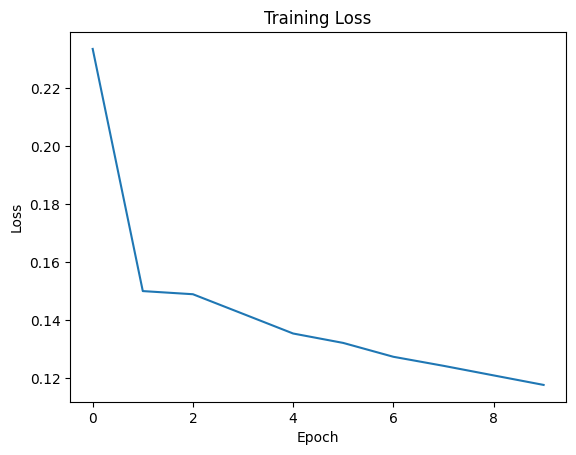

In [45]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [46]:
import IPython.display as ipd# Plot training loss
# Optional: Listen to input audio inline
print("Noisy audio:")
ipd.display(ipd.Audio(noisy, rate=config["sample_rate"]))
print("Clean audio:")
ipd.display(ipd.Audio(clean, rate=config["sample_rate"]))


Noisy audio:


Clean audio:


In [47]:
from google.colab import files
files.download('deepspeech_colab.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>